# Explaining RL Decisions with Trajectories

This file contains code used for generating results of the gridworld experiments.

In [1]:
# Regular data science libraries
import numpy as np
import pandas as pd
import json
import os
import pickle
import random


# DNN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Import utility functions from other files
from utils import generate_model, dp, generate_offline_data
from env import Agent, Environment


# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('ieee')


# Clustering libraries
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from scipy.stats import wasserstein_distance

# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


### Instantiate the Environment

Pick one of the three provided environments: FourRooms, 7x7 (default), or 5x5. The environment implementation is provided in a script attached with this notebook.

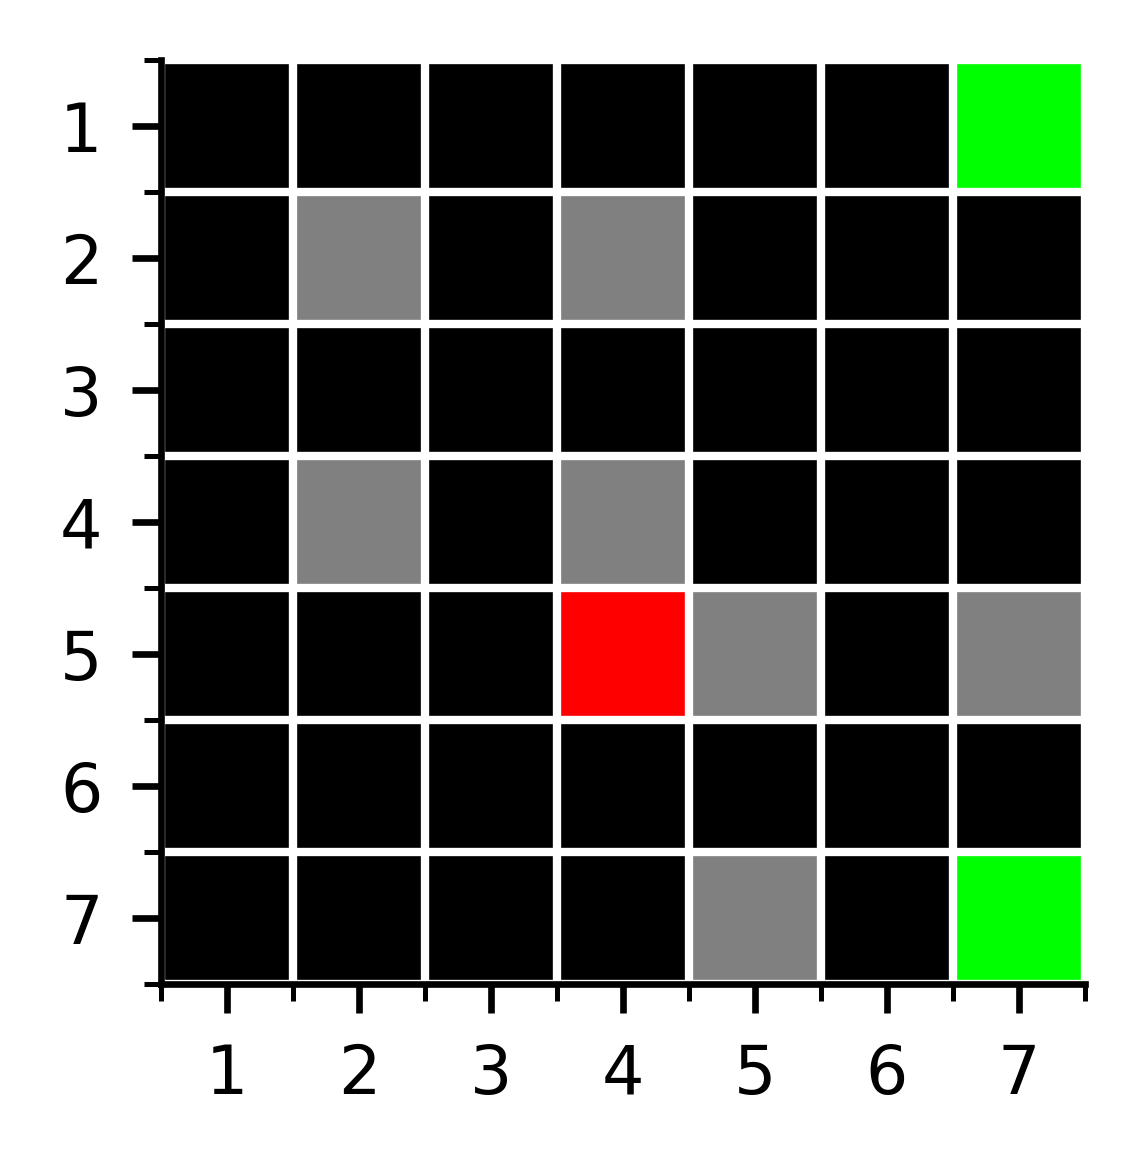

In [2]:
# # 7x7 Gridworld Environment

action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
reward_dict = {1:0, -1:1, -0.1:2, 0:3}

#####

# Environment Definition
env_width = 7
env_height = 7
env = Environment(dim=(env_width, env_height),
                  starts=[(2, 0), (6, 2), (2,4)],
                  terminals={(0, 6): +1, (6, 6): +1, (4, 3): -1},
                  obstacles=[[1, 1], [1, 3], [3, 1], [3, 3], [4,4], [6, 4], [4,6]],
                  stoc=0.)

env.render(title='7x7 Gridworld')

# Initialize the agent
agent = Agent(env)

#####

### Collecting offline trajectory data

In [3]:
# Generate offline data for the training
num_episodes_dyna = 2
num_agents_dyna = 20
max_traj_len = 20
num_pos_trajs = 500
num_neg_trajs = 100
offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

#####

Training 20 Agents


100%|██████████| 20/20 [00:00<00:00, 35.04it/s]

# POS TRAJs 1
# NEG TRAJs 1
# POS TRAJs 2
# POS TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# POS TRAJs 7
# NEG TRAJs 2
# POS TRAJs 8
# POS TRAJs 9
# POS TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# NEG TRAJs 3
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# NEG TRAJs 4
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# NEG TRAJs 5
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# NEG TRAJs 6
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# NEG TRAJs 7
# NEG TRAJs 8
# POS TRAJs 43
# NEG TRAJs 9
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# NEG TRAJs 10
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
# POS TRAJs 51
# POS TRAJs 52
# NEG TRAJs 11
# POS TRAJs 53
# NEG TRAJs 12
# POS TRAJs 54
# POS TRAJs 55
# POS TRAJs 5

In [4]:
offline_data[:2]

[[(18, 2, -0.1, 19),
  (19, 2, -0.1, 20),
  (20, 1, -0.1, 13),
  (13, 1, 1.0, 6),
  (6, 0, 0, 6)],
 [(18, 1, -0.1, 11),
  (11, 1, -0.1, 4),
  (4, 2, -0.1, 5),
  (5, 2, 1.0, 6),
  (6, 0, 0, 6)]]

In [5]:
## If you are planning to pickle these trajectories and use them instead of generating them every time...
# results_save_dir = './gridworld_results/grid_7by7/'
# with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'wb') as f:
#     pickle.dump(offline_data, f)

# with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'rb') as f:
#     offline_data = pickle.load(f)

In [6]:
# Plot a trajectory to check if the data has been correctly formed
# env.plot_traj(offline_data[-1])

## Sequential Encoder

We use sequential encoder to parse the offline data and create clusters of the trajectories which will be used for attributing the decisions in the later steps.

In [7]:
def tokenizer(trajectories, state_space_dim, action_dict, reward_dict, max_traj_len = 25):
    """
        Tokenizer for capturing gridworld trajectories
    """

    action_space_dim = len(action_dict)
    reward_set_dim = len(reward_dict)
    
    # TOKEN IDs
    # 1 START TOKEN
    # 2 END TOKEN
    # 0 PAD TOKEN
    # STATE TOKENs
    # ACTION TOKENs
    # REWARD TOKENs
    
    complete_traj_tokens = []
    
    for traj in trajectories:
        # Traj contains (s,a,r,s')
        # We generate tokens for 's', 'a' and 'r'
        
        traj_tokens = []
        
        # Start token
        traj_tokens.append(1)
        
        for sars_ in traj:
            s = sars_[0]
            a = sars_[1]
            r = sars_[2]
            
            # State
            traj_tokens.append(3 + s)
            
            # Action
            traj_tokens.append(3 + state_space_dim + a)
            
            # Reward
            traj_tokens.append(3 + state_space_dim + action_space_dim + reward_dict[r])
        
        # Remove action and reward for terminal state, TO BE USED ONLY when (s_terminal, a_random, reward = 0, s_terminal) exists at the end of trajectory data
        traj_tokens.pop()
        traj_tokens.pop()
        
        # End token
        traj_tokens.append(2)
        
        # Pad with zero tokens
        if max_traj_len + 3 - len(traj) > 0:
            traj_tokens = traj_tokens + [0]*(3*(max_traj_len + 3 - len(traj)))
        
        complete_traj_tokens.append(torch.LongTensor(traj_tokens))
    
    return complete_traj_tokens

vocab_size = 3 + env_width*env_height + len(action_dict) + len(reward_dict)

tokenized_data = tokenizer(offline_data, 
                          state_space_dim = env_width*env_height, 
                          action_dict = action_dict, 
                          reward_dict = reward_dict, 
                          max_traj_len = max_traj_len)

In [24]:
class LSTMEncoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.token_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size)

    def forward(self, traj):
        embeds = self.token_embeddings(traj)
        o, (h_n, c_n) = self.lstm(embeds.view(len(traj), 1, -1)) # Batch first is false, -> Input shape (L(seq len), N(num seq), H_in(hidden size))
        # The LSTM output contains :
        # o - Outputs of individual cells : shape (L, N, H)
        # h_n - Final hidden state
        # c_n - Final cell state
        return o[-1], (h_n, c_n)
    
class LSTMDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_size,
                                      )

        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden_state, cell_state):
        # Input is START TOKEN
        # Hidden state, Cell state are taken from encoder's output

        # Get embedding
        embedded = self.embedding(input)        
        output = embedded.view(len(input), 1, -1)
        
        # Run LSTM to decode the trajectory
        output, _ = self.lstm(output, (hidden_state, cell_state))
        
        # Convert LSTM logits to vocab size softmax 
        out = self.out(output.squeeze(1))
        output = F.log_softmax(out, dim=1)
        
        return output

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, traj):
        traj_embedding = self.encoder(traj[1:])
        decoded_traj = self.decoder(traj[:-1], traj_embedding[1][0], traj_embedding[1][1])
        return decoded_traj, traj_embedding

traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)

In [25]:
# Hyperparameters 
from torch.optim import Adam
num_epochs = 25

# Optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = Adam(model.parameters(), lr=0.001)

In [26]:

model.train()

for epoch_id, epoch in enumerate(range(num_epochs)):
    total_loss = 0
    for traj_id, traj in enumerate(tokenized_data):
        optimizer.zero_grad()
        
        # Get decoded trajectory and its embedding
        decoded_traj, traj_embedding = model(traj)
        # Loss
        loss = F.nll_loss(decoded_traj.view(-1, vocab_size),
                          traj[1:].contiguous().view(-1),
                          ignore_index=0)
        
        # Optimize the model
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # Record loss
        total_loss += loss.data.item()

    total_loss = total_loss / 100
    
    print(f'Epoch: {epoch_id + 1}, Loss:{total_loss}')

Epoch: 1, Loss:9.402006101310253
Epoch: 2, Loss:4.718514969050884
Epoch: 3, Loss:3.8978658237308266
Epoch: 4, Loss:3.3167417596280573
Epoch: 5, Loss:2.8249453111365437
Epoch: 6, Loss:2.409854560941458
Epoch: 7, Loss:2.1422112656012176
Epoch: 8, Loss:1.931256695985794
Epoch: 9, Loss:1.7600152351707221
Epoch: 10, Loss:1.6242950712237507
Epoch: 11, Loss:1.5113122855685652
Epoch: 12, Loss:1.4146370786800981
Epoch: 13, Loss:1.348959698593244
Epoch: 14, Loss:1.3107814619038254
Epoch: 15, Loss:1.2623427356220782
Epoch: 16, Loss:1.2032228096481412
Epoch: 17, Loss:1.1552177800703793
Epoch: 18, Loss:1.0829881411278621
Epoch: 19, Loss:1.0001120444387197
Epoch: 20, Loss:0.951733312215656
Epoch: 21, Loss:0.9290034491196275
Epoch: 22, Loss:0.9003197731915862
Epoch: 23, Loss:0.8779797709360718
Epoch: 24, Loss:0.8615318092610686
Epoch: 25, Loss:0.8478074254561215


In [27]:
torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_7.pth')
traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_5.pth'))
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_fourrooms.pth'))
model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_7.pth'))

<All keys matched successfully>

In [28]:
# Load and generate trajectory embeddings
traj_embeddings = []

for traj_id, traj in enumerate(tokenized_data):
    with torch.no_grad():
        decoded_traj, traj_embedding = model(traj)
        traj_embeddings.append(torch.cat(traj_embedding[1], axis=-1).numpy().reshape(-1))

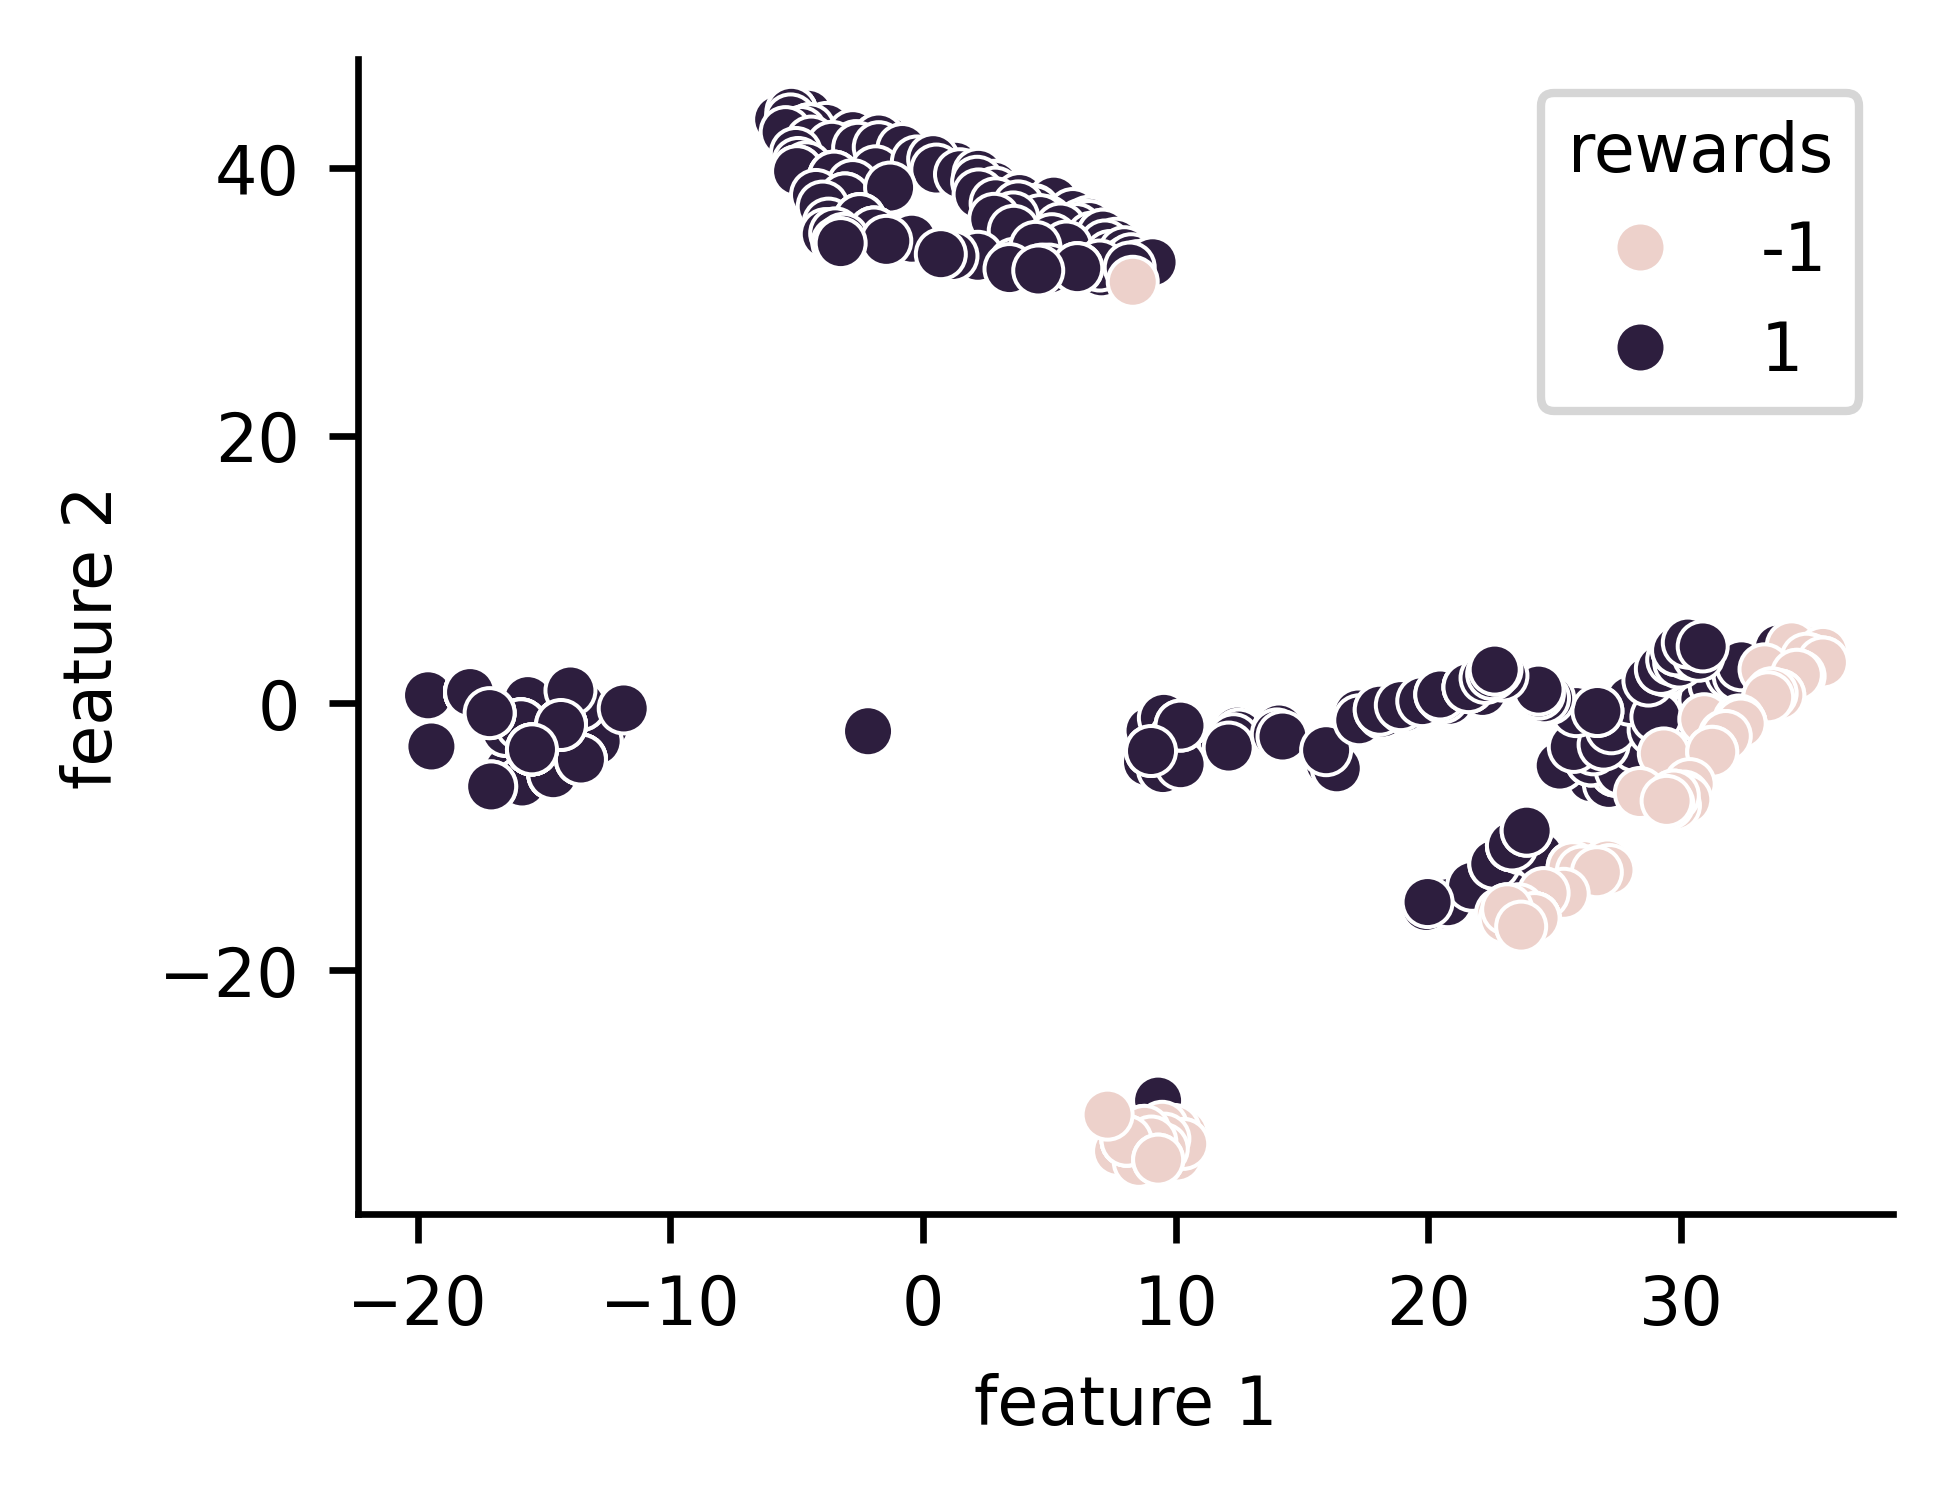

In [37]:
from sklearn.manifold import TSNE  # Import T-SNE

# ... (Your code for generating traj_embeddings) ...

# T-SNE Transformation
traj_embeddings_array = np.array(traj_embeddings)
tsne = TSNE(n_components=2, random_state=42)  # Set parameters as desired
tsne_traj_embeddings = tsne.fit_transform(traj_embeddings_array)

# Update plotting data
plotting_data = {'feature 1': tsne_traj_embeddings[:, 0], 'feature 2': tsne_traj_embeddings[:, 1],
                 'rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs}
df = pd.DataFrame(plotting_data)
plt.figure()
sns.scatterplot(x='feature 1', y='feature 2', hue='rewards', data=df)
# plt.title('PCA: Trajectory Embeddings')
# plt.legend()
plt.show()

# plt.figure()
# data_ax = sns.scatterplot(x='x',
#                           y='y',
#                           hue='labels',
#                           palette='deep',
#                           data=df,
#                           legend=True)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
# plt.title('PCA: Cluster Embeddings using ' + embed_gen_config['method_name'])
# plt.show()

/home/jovyan/xrl_with_trajectories/xrl/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


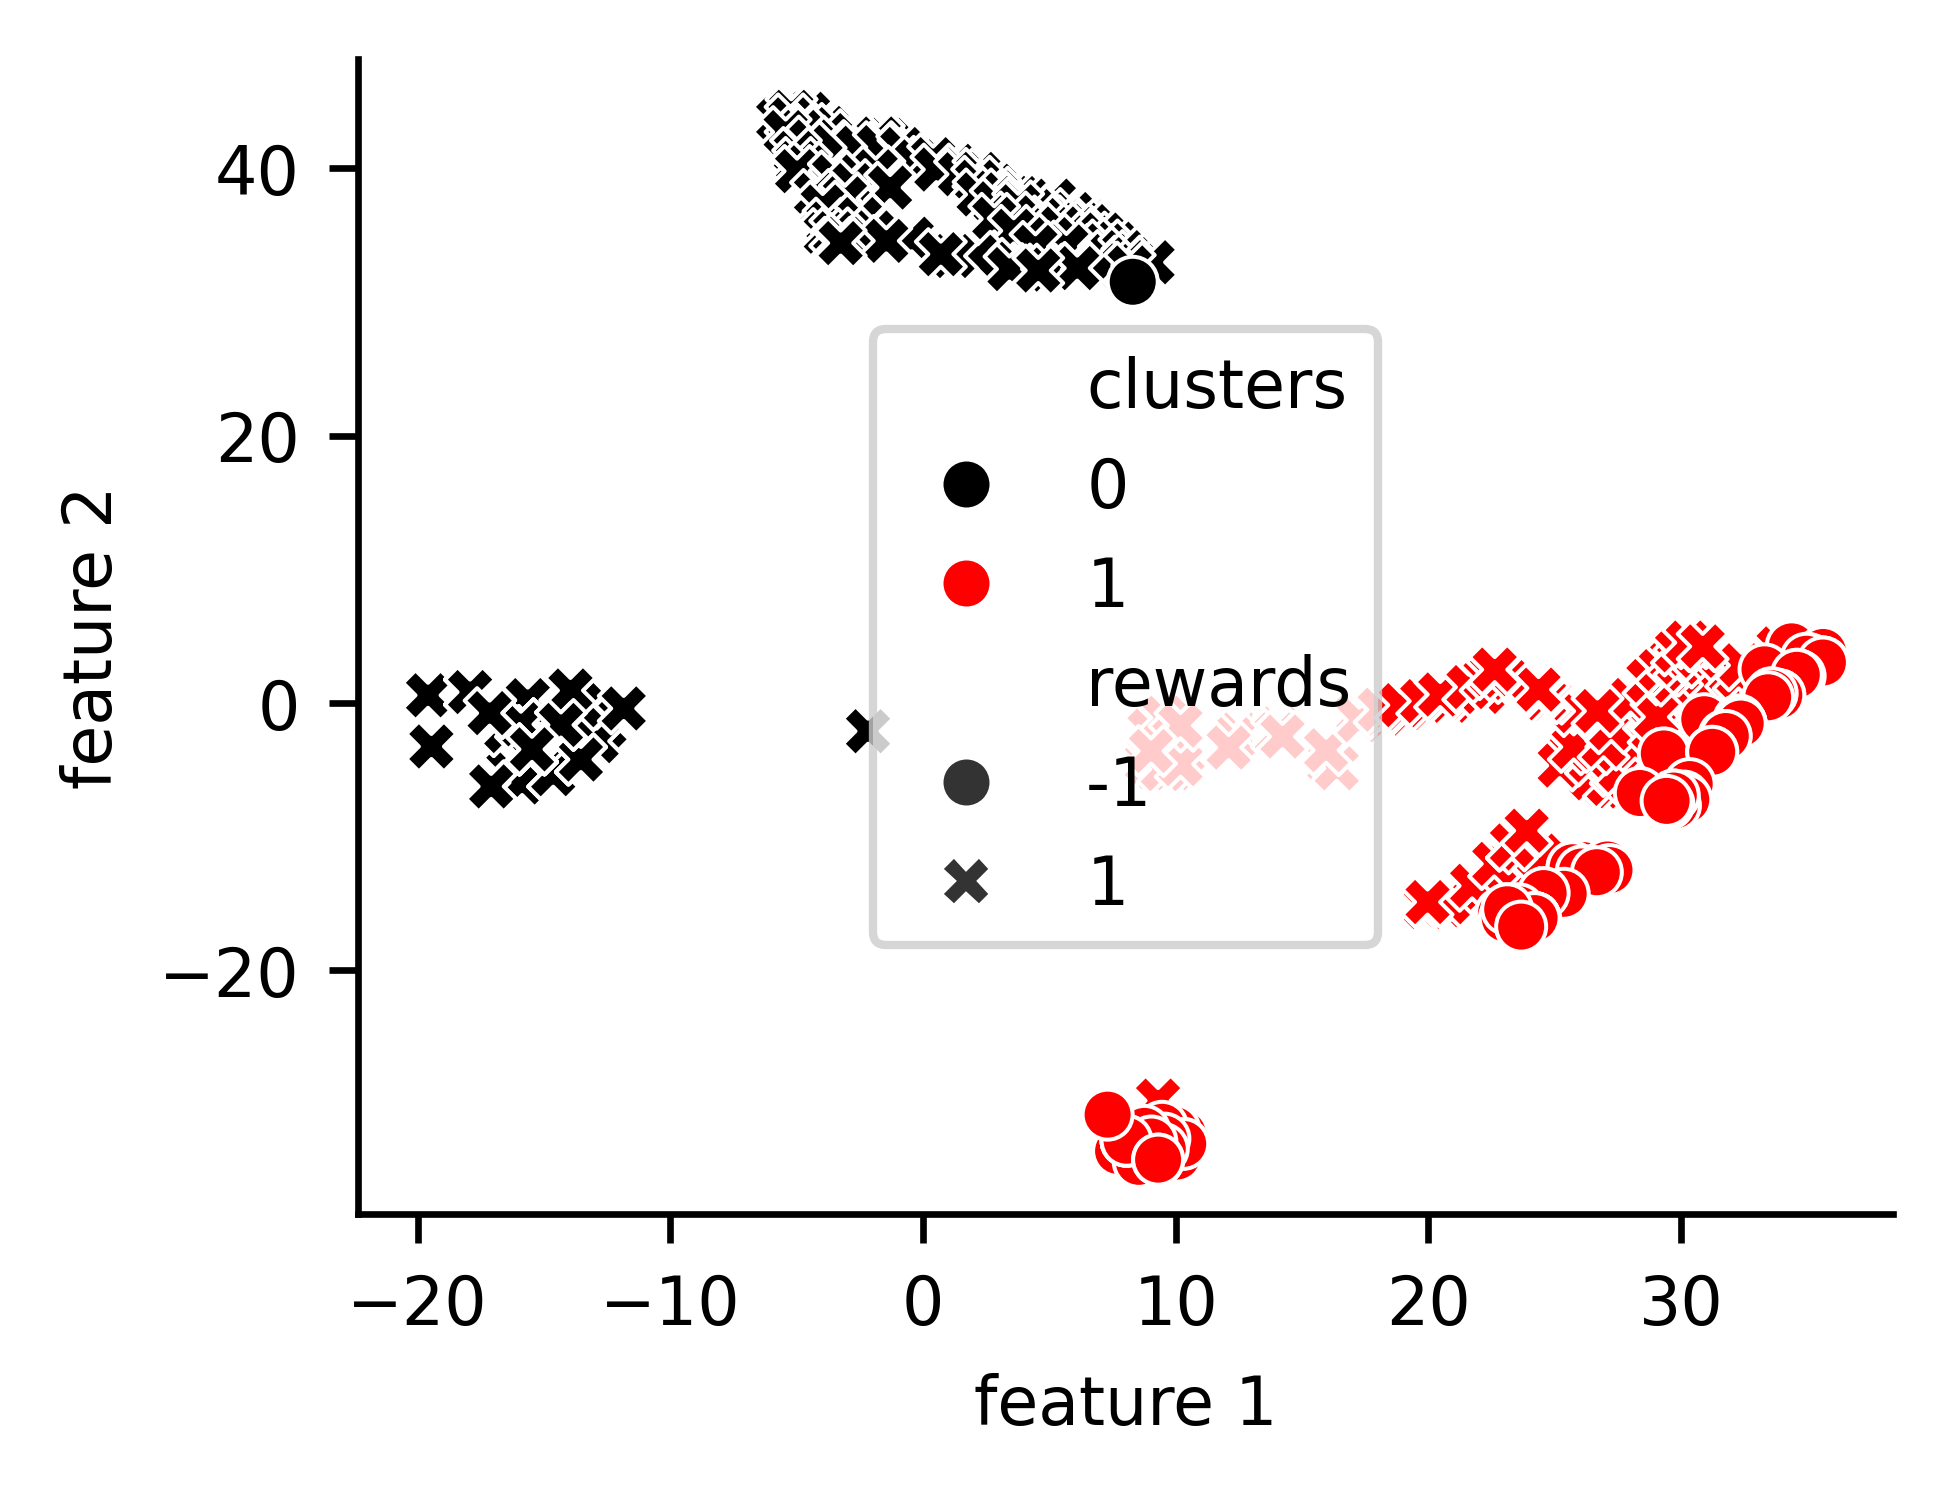

Adjusted Rand Index: 0.24819549903145444


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Assuming traj_embeddings, num_pos_trajs, and num_neg_trajs are defined elsewhere

# T-SNE Transformation
traj_embeddings_array = np.array(traj_embeddings)
tsne = TSNE(n_components=2, random_state=42)
tsne_traj_embeddings = tsne.fit_transform(traj_embeddings_array)

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(tsne_traj_embeddings)
cluster_labels = kmeans.labels_

# Update plotting data
plotting_data = {
    'feature 1': tsne_traj_embeddings[:, 0], 
    'feature 2': tsne_traj_embeddings[:, 1],
    'rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs,
    'clusters': cluster_labels
}

df = pd.DataFrame(plotting_data)

# Plotting the t-SNE results with cluster assignments
plt.figure()
sns.scatterplot(x='feature 1', y='feature 2', hue='clusters', style='rewards', data=df)
plt.show()

# Calculate ARI
true_labels = plotting_data['rewards']
ari_score = adjusted_rand_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari_score}")


In [44]:

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers =2
initial_centers = kmeans_plusplus_initializer(tsne_traj_embeddings, amount_initial_centers).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
xmeans_instance = xmeans(tsne_traj_embeddings, initial_centers, 10)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())
print("Clusters:", clusters)
print('Number of clusters', len(clusters))

Total WCE: 5786.1755149336905
Clusters: [[3, 4, 7, 8, 9, 10, 11, 12, 13, 17, 18, 27, 28, 29, 33, 36, 37, 40, 43, 44, 45, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 63, 64, 66, 67, 68, 70, 71, 73, 75, 76, 78, 80, 81, 83, 84, 86, 92], [239, 240, 241, 242, 243, 244], [21, 24, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238], [0, 2, 5, 6, 14, 15, 16, 20, 22, 23, 25, 26, 30

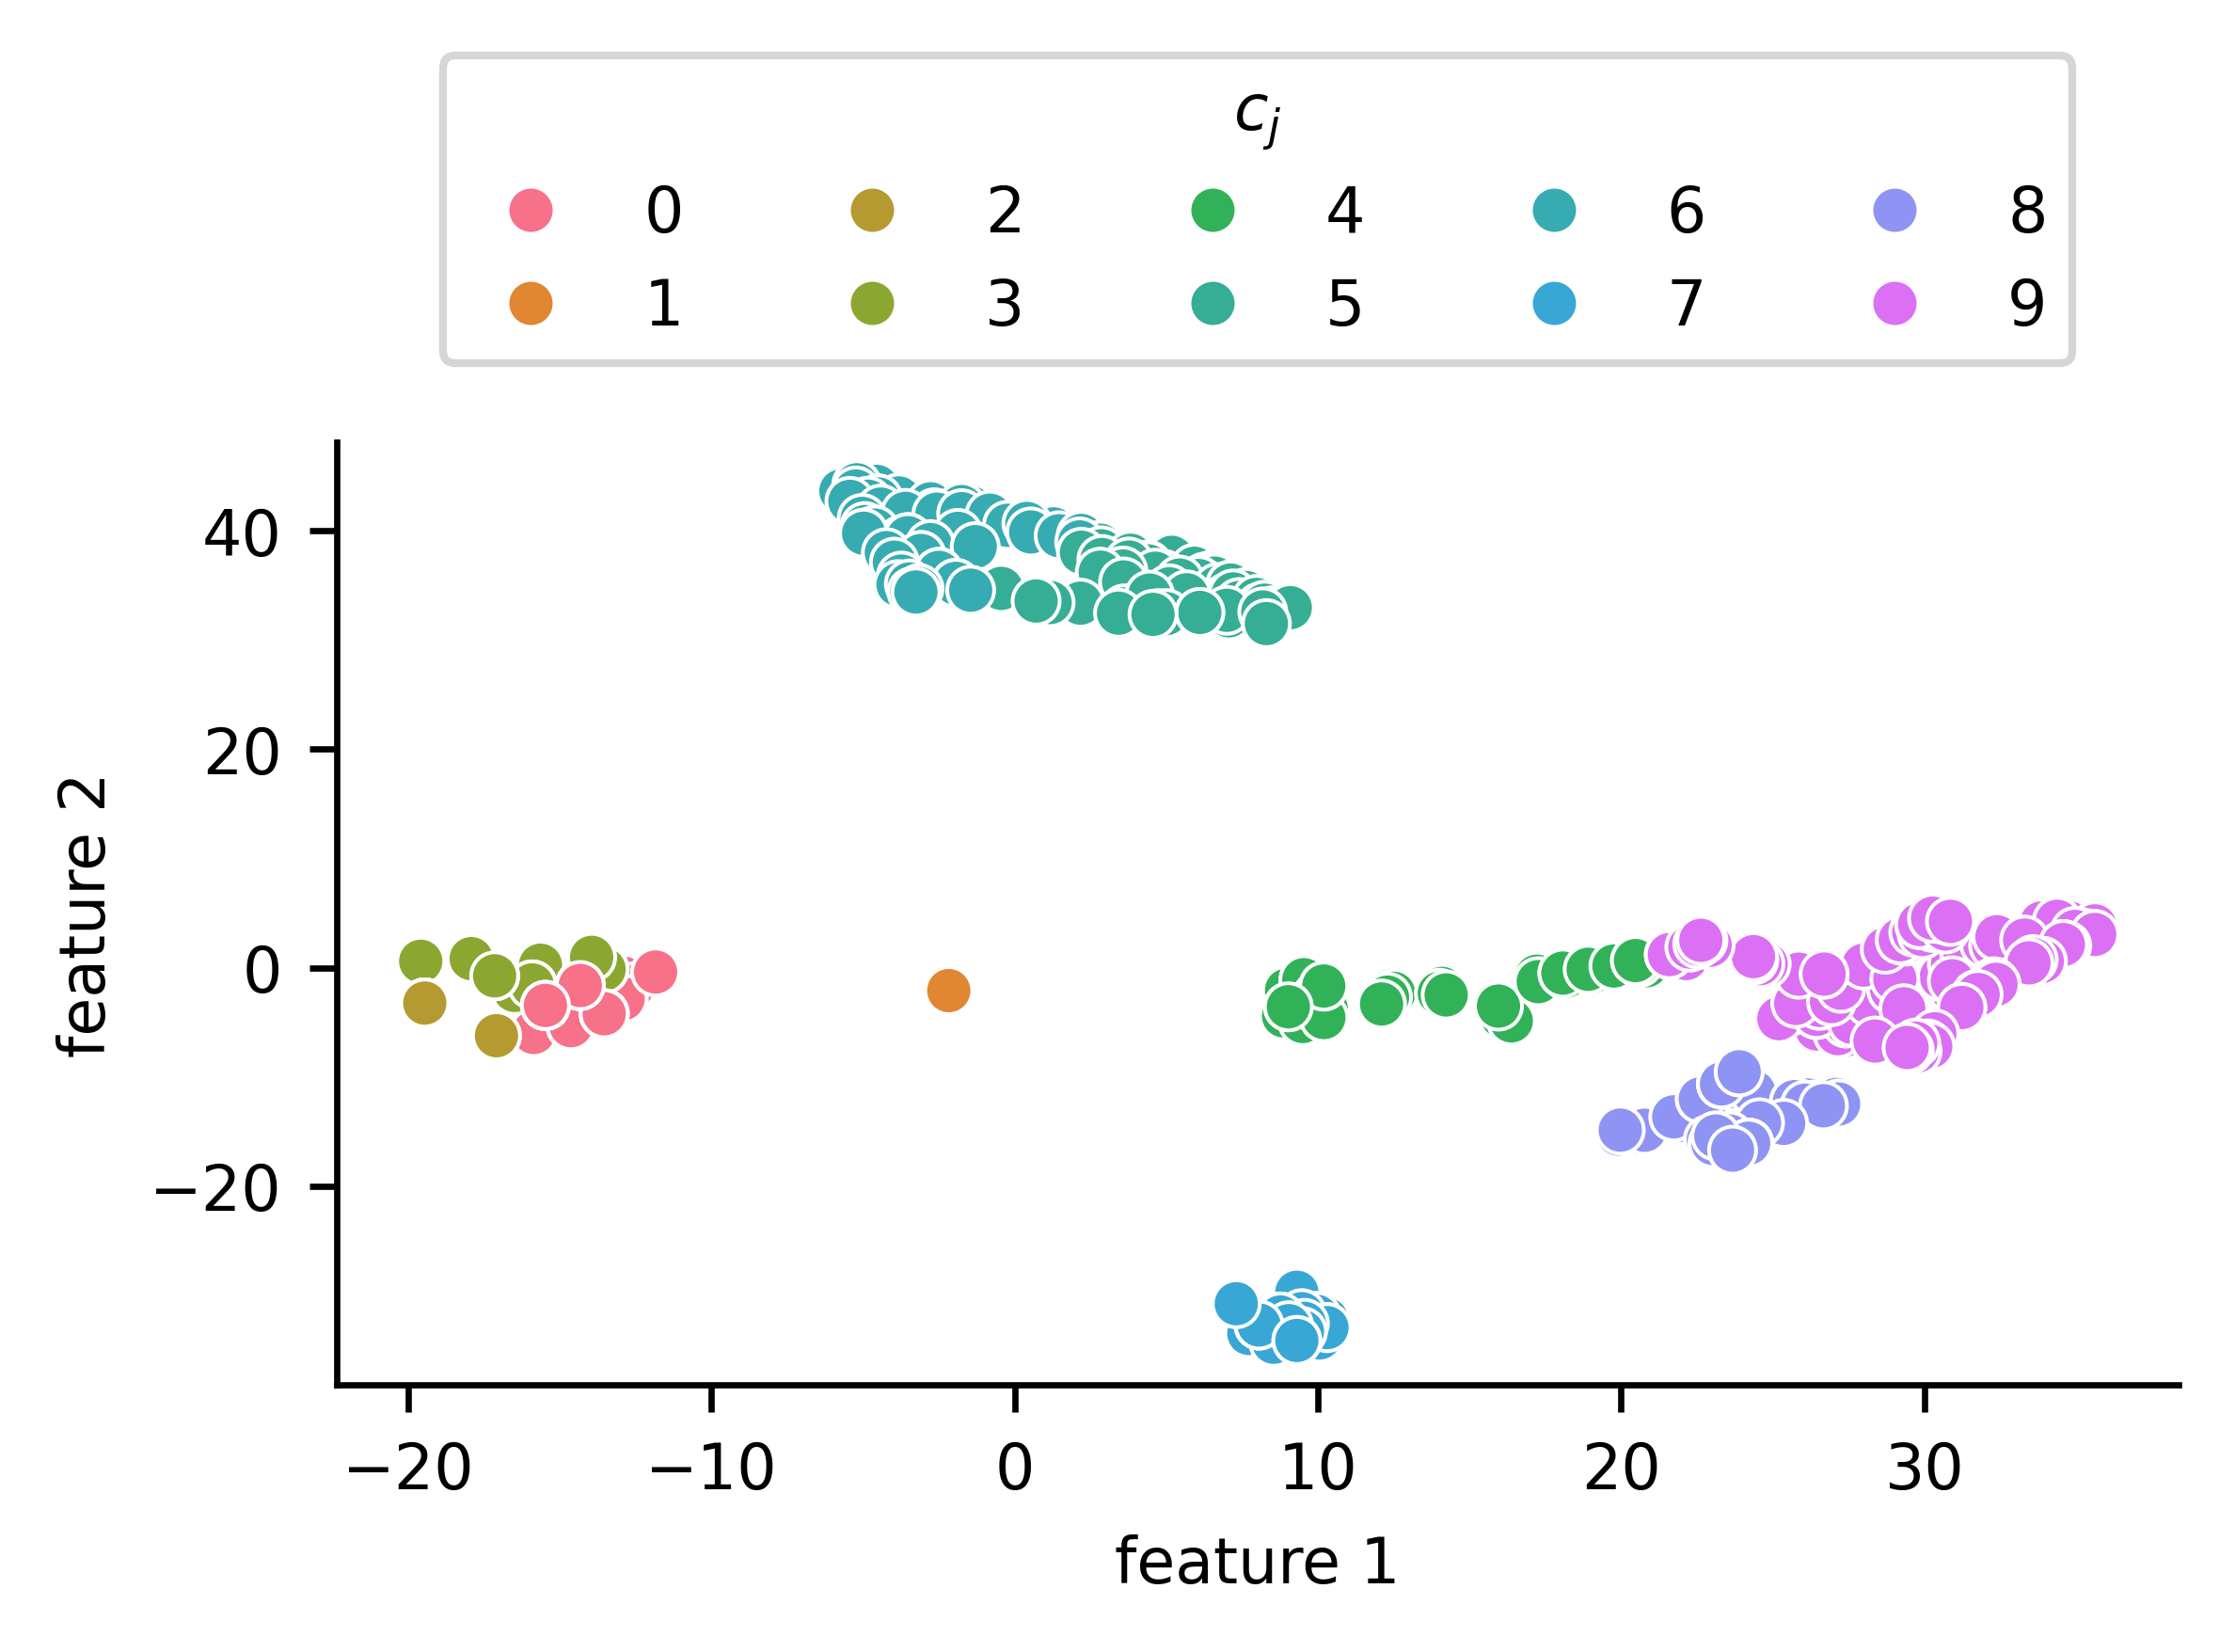

In [45]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id

palette = sns.color_palette('husl', len(clusters) + 1)
# pca_traj = PCA(n_components=2)
# pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
plotting_data = {'feature 1': tsne_traj_embeddings[:, 0],
                 'feature 2': tsne_traj_embeddings[:, 1],
                 'cluster id': traj_cluster_labels}
df = pd.DataFrame(plotting_data)

plt.figure(figsize=(4,3))
data_ax = sns.scatterplot(x='feature 1',
                          y='feature 2',
                          hue='cluster id',
                          palette=palette[:len(clusters)],
                          data=df,
                          legend=True)
plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
# plt.legend(title = '$c_{j}$', loc='center left', bbox_to_anchor=(1., 0.7), ncol=2)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
plt.tight_layout()
plt.savefig('./traj_clustering_grid.pdf')
plt.show()

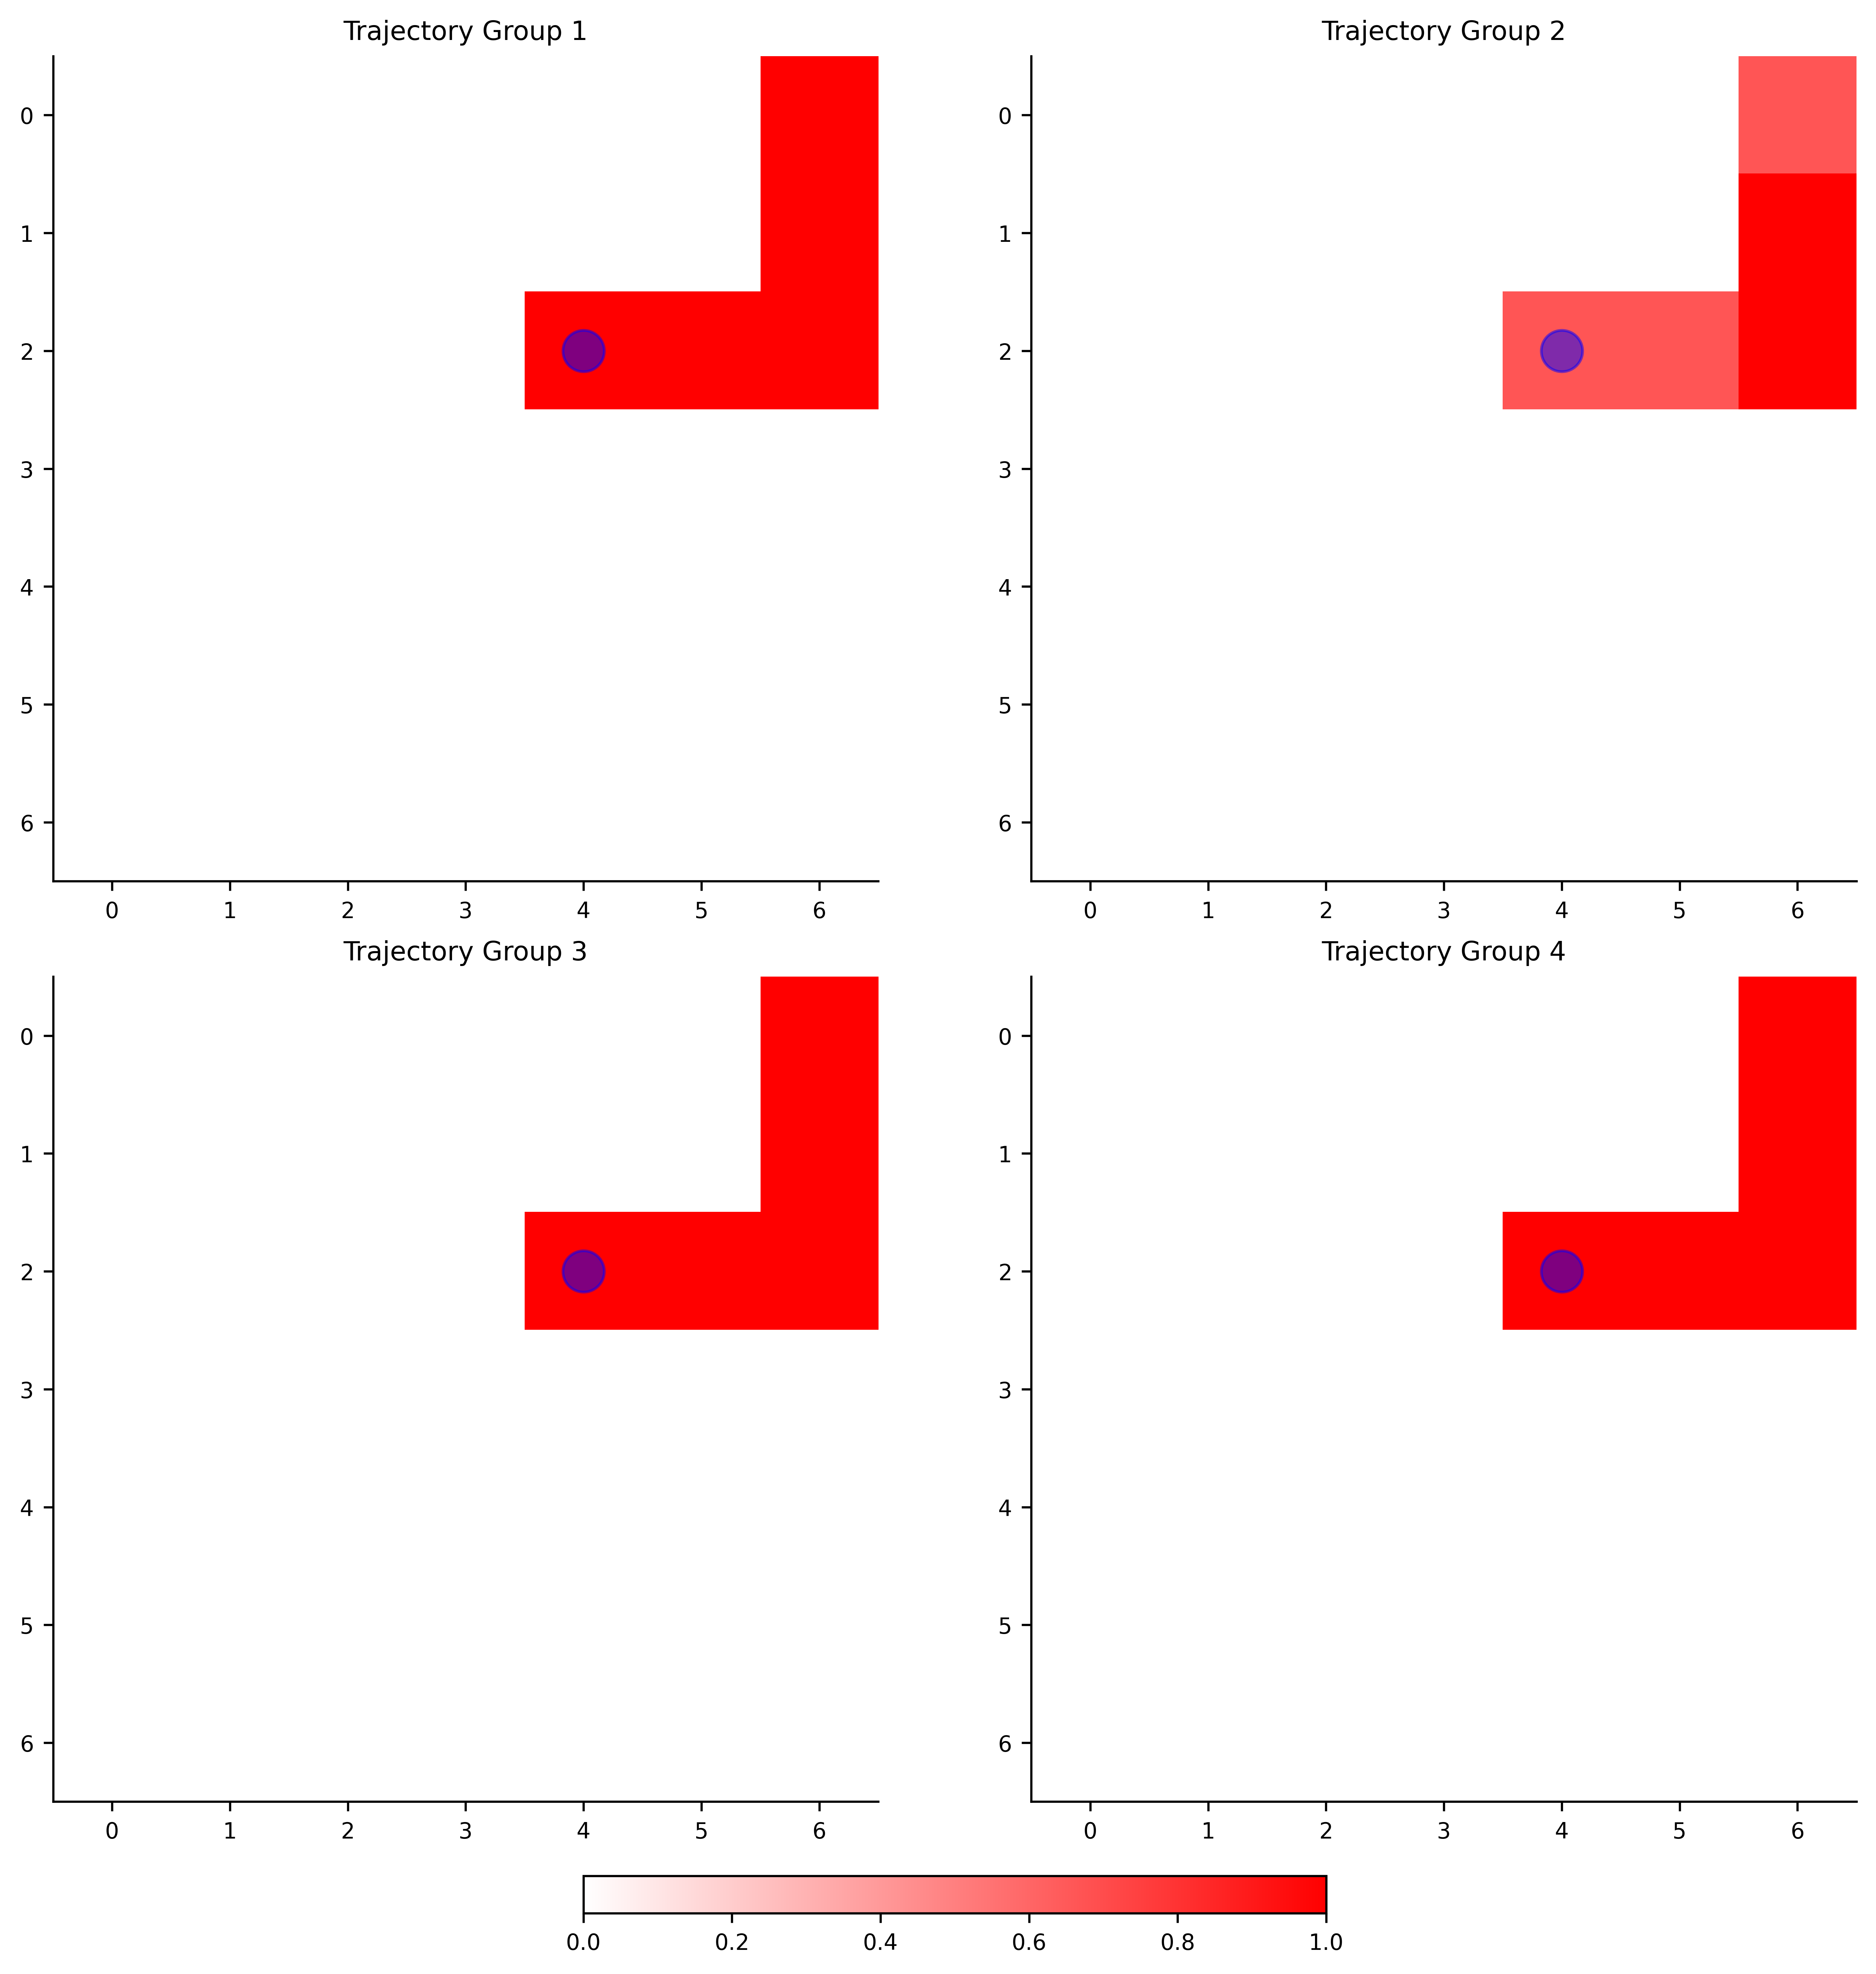

In [51]:
# Assuming 'clusters' is a list of clusters, each containing indices of trajectories in 'offline_data'
selected_clusters_indices = [0,1,2,3]  # Example selection of clusters for comparison

# Initialize a list to hold collected trajectories and starting points for each cluster
collected_clusters_trajectories = []
collected_clusters_starts = []

for cluster_index in selected_clusters_indices:
    collected_trajectories = []
    start_points = np.zeros(shape=env.dim)  # Assuming env.dim gives the dimension of the grid

    for trajectory_idx in clusters[cluster_index]:
        selected_trajectory = offline_data[trajectory_idx]
        collected_trajectories.append(selected_trajectory)
        
        # Assuming each trajectory[0] is the starting state and you can convert it to grid coordinates
        start_state = selected_trajectory[0][0]  # [0] for the first state-action-reward tuple, [0] for the state
        start_i, start_j = env.idx_to_coords(start_state)  # Convert start state to coordinates
        start_points[start_i, start_j] += 1  # Increment start point count

    collected_clusters_trajectories.append(collected_trajectories)
    collected_clusters_starts.append(start_points)

env.plot_traj_densities_with_starts(collected_clusters_trajectories, collected_clusters_starts)

# Assuming 'clusters' is a list of clusters, each containing indices of trajectories in 'offline_data'
selected_clusters_indices = [4,5,6,7]  # Example selection of clusters for comparison

# Initialize a list to hold collected trajectories and starting points for each cluster
collected_clusters_trajectories = []
collected_clusters_starts = []

for cluster_index in selected_clusters_indices:
    collected_trajectories = []
    start_points = np.zeros(shape=env.dim)  # Assuming env.dim gives the dimension of the grid

    for trajectory_idx in clusters[cluster_index]:
        selected_trajectory = offline_data[trajectory_idx]
        collected_trajectories.append(selected_trajectory)
        
        # Assuming each trajectory[0] is the starting state and you can convert it to grid coordinates
        start_state = selected_trajectory[0][0]  # [0] for the first state-action-reward tuple, [0] for the state
        start_i, start_j = env.idx_to_coords(start_state)  # Convert start state to coordinates
        start_points[start_i, start_j] += 1  # Increment start point count

    collected_clusters_trajectories.append(collected_trajectories)
    collected_clusters_starts.append(start_points)

env.plot_traj_densities_with_starts(collected_clusters_trajectories, collected_clusters_starts)## Training AE to encode trajectories

In [14]:
# def compute_traveled_vectors(trajectories):
#     """
#     Computes the vectors traveled for a list of trajectories.

#     Args:
#     - trajectories: A list of trajectories, each trajectory is a list of states,
#       and each state is represented by coordinates (i, j).

#     Returns:
#     - A list of vectors representing the movement from the start to the end of each trajectory.
#       Each vector is represented as (delta_i, delta_j).
#     """
#     traveled_vectors = []

#     for traj in trajectories:
#         if not traj:  # Check if the trajectory is empty
#             continue
#         for vector in traj:
#             traveled_vectors.append([vector[0], vector[1]])

# #         # Extract start and end points
# #         start_point = traj[0]  # First state's coordinates
# #         end_point = traj[-1]  # Last state's coordinates

# #         # Compute the traveled vector
# #         vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])
        

#     return traveled_vectors

# traveled_vectors = compute_traveled_vectors(offline_data)
# traveled_vectors_tensor = torch.tensor(traveled_vectors, dtype=torch.float32)

# # Initialize an empty list to store rewards
# rewards = []

# # Iterate through each vector in traveled_vectors_tensor to assign rewards
# for vec in traveled_vectors_tensor:
#     if vec.tolist() == [18, 2]:  # Check if the vector matches the condition
#         rewards.append(1)
#     else:
#         rewards.append(-1)

# # Convert the list of rewards into a tensor
# rewards_tensor = torch.tensor(rewards, dtype=torch.float32).view(-1, 1)

# # Concatenate traveled_vectors with rewards for each entry
# data_with_rewards = torch.cat((traveled_vectors_tensor, rewards_tensor), dim=1)


# class TrajectoryDataset(Dataset):
#     def __init__(self, data):
#         self.data = data
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         # Return the entire data entry (including the reward) as both input and target
#         return self.data[idx], self.data[idx]  # (input, target)


In [46]:
import torch
from torch.utils.data import Dataset
import random

class DualDataset(Dataset):
    def __init__(self, features):
        # Flatten the features into a single list of lists
        self.features = [[f[0], f[2]] for feature_list in features for f in feature_list]
        print(len(self.features))
        self.rewards = [f[2] for feature_list in features for f in feature_list]
        print(len(self.rewards))
    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        # Directly access the feature at the given index
        anchor_data = self.features[index]
        anchor_reward = anchor_data[1]

        # Initialize lists to hold possible positive and negative sample indices
        positive_indices = []
        negative_indices = []

        # Classify other indices as potential positive or negative samples
        for idx, reward in enumerate(self.rewards):
            if idx != index:  # Ensure not comparing with itself
                if abs(reward - anchor_reward) > 0.5:
                    negative_indices.append(idx)
                else:
                    positive_indices.append(idx)

        # Handle edge case where no suitable positive/negative samples are found
        pos_idx = random.choice(positive_indices) if positive_indices else index
        neg_idx = random.choice(negative_indices) if negative_indices else index

        positive_data = self.features[pos_idx]
        negative_data = self.features[neg_idx]

        # Convert to tensors before returning
        anchor_data_tensor = torch.tensor(anchor_data, dtype=torch.float)
        positive_data_tensor = torch.tensor(positive_data, dtype=torch.float)
        negative_data_tensor = torch.tensor(negative_data, dtype=torch.float)

        return anchor_data_tensor, positive_data_tensor, negative_data_tensor

dual_dataset = DualDataset(offline_data)
embedding_loader = DataLoader(dual_dataset, batch_size=1, shuffle=True)

5471
5471


In [47]:
def contrastive_loss(anchor_emb, positive_emb, negative_emb, margin=0.5):
    """
    Compute the contrastive loss given batches of anchor, positive, and negative embeddings.
    
    Args:
    - anchor_emb: Tensor of anchor embeddings
    - positive_emb: Tensor of positive embeddings (similar to the anchor)
    - negative_emb: Tensor of negative embeddings (dissimilar to the anchor)
    - margin: Margin by which negative pairs should be separated
    
    Returns:
    - loss: Computed contrastive loss
    """
    # Positive pair similarity (smaller values mean more similar)
    pos_distance = F.pairwise_distance(anchor_emb, positive_emb, p=20)
    # Negative pair similarity
    neg_distance = F.pairwise_distance(anchor_emb, negative_emb, p=2)
    
    # Contrastive loss: Maximize the distance between negative pairs
    # and minimize the distance between positive pairs
    losses = F.relu(pos_distance - neg_distance + margin)
    
    return losses.mean()

class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(2, 2)  # Assuming the input data is flattened if necessary; reduces dimension from 3 to 2
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 2)  # Attempts to reconstruct the original 3-dimensional data from the 2D encoded form
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Create the autoencoder model
model = SimpleAutoencoder()


In [48]:
# Define the model, optimizer, and contrastive loss function as described previously
num_epochs = 3
model = SimpleAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    total_loss = 0
    # Assuming you have a way to get anchor, positive, and negative samples
    for anchor, positive, negative in embedding_loader:  # data_loader to provide (anchor, positive, negative)
        # print(f'anchor: {anchor} positive:  {positive}')
        optimizer.zero_grad()
        
        _, anchor_emb = model(anchor)
        # print(f'anchor: {anchor}')
        # print(f'anchor_emb: {anchor_emb}')
        _, positive_emb = model(positive)
        # print(f'positive: {positive}')
        # print(f'positive_emb: {positive_emb}')
        _, negative_emb = model(negative)
        # print(f'negative: {negative}')
        # print(f'negative_emb: {negative_emb}')
        
        # Compute contrastive loss
        cont_loss = contrastive_loss(anchor_emb, positive_emb, negative_emb, margin=0.5)
        
        # Optionally, compute reconstruction loss if you're using it
        # recon_loss = F.mse_loss(reconstructed_anchor, anchor)  # Example for anchor
        
        # Combine losses if using both, or just use contrastive loss
        loss = cont_loss  # Or, e.g., loss = recon_loss + cont_loss
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Print average loss for the epoch
    print(f'Epoch: {epoch + 1}, Avg Loss: {total_loss / len(embedding_loader)}')

KeyboardInterrupt: 

In [18]:
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_5.pth')
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_fourrooms.pth')
torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_7.pth')

In [19]:
unique_combinations = set()

start_end_trajs = [[(sub_array[0][0], sub_array[0][2]), (sub_array[-2][0], sub_array[-2][2])] for sub_array in offline_data]

differences = []
rewards = []
rewards_for_state = [] 
state_embeddings = []
for trajs in start_end_trajs:
    # Convert trajectory points to tensors and encode them
    # print(trajs[1])
    rewards.append(trajs[1][1])
    start_embed = model.encoder(torch.tensor(trajs[0]).float())
    end_embed = model.encoder(torch.tensor(trajs[1]).float())
    
    state_embeddings.append(start_embed.detach().numpy())
    rewards_for_state.append(trajs[0][1])
    state_embeddings.append(end_embed.detach().numpy())
    rewards_for_state.append(trajs[1][1])
    
    # Calculate differences in x and y, round to 5 decimal places
    difference  = end_embed - start_embed  # This will be a tensor
    difference = difference.detach().numpy()
    differences.append(difference)
    difference_x_y = (round(difference[0].item(), 5), round(difference[1].item(), 5))
    
    # Add the rounded difference tuple to the 'unique_combinations' set
    unique_combinations.add(difference_x_y)

# The set 'unique_combinations' now contains all unique combinations of differences

# Display unique combinations
for combination in unique_combinations:
    print(combination)

# Count of unique combinations
unique_combinations_count = len(unique_combinations)

print(f"Count of unique combinations: {unique_combinations_count}")

(-0.37348, 1.03051)
(0.43373, -0.77367)
(0.18049, -0.91096)
(-0.44102, 0.9939)
(-0.39037, 1.02136)
(-0.40725, 1.01221)
(0.24802, -0.87435)
(-0.33972, 1.04882)
(-0.47478, 0.97559)
Count of unique combinations: 9


### Encode trajectories in the offline datasetdata_with_rewards

In [20]:
rewards_for_state[:10]

[-0.1, 1.0, -0.1, 1.0, -0.1, 1.0, -0.1, 1.0, -0.1, 1.0]

### PCA analysis of the trajectory embeddings

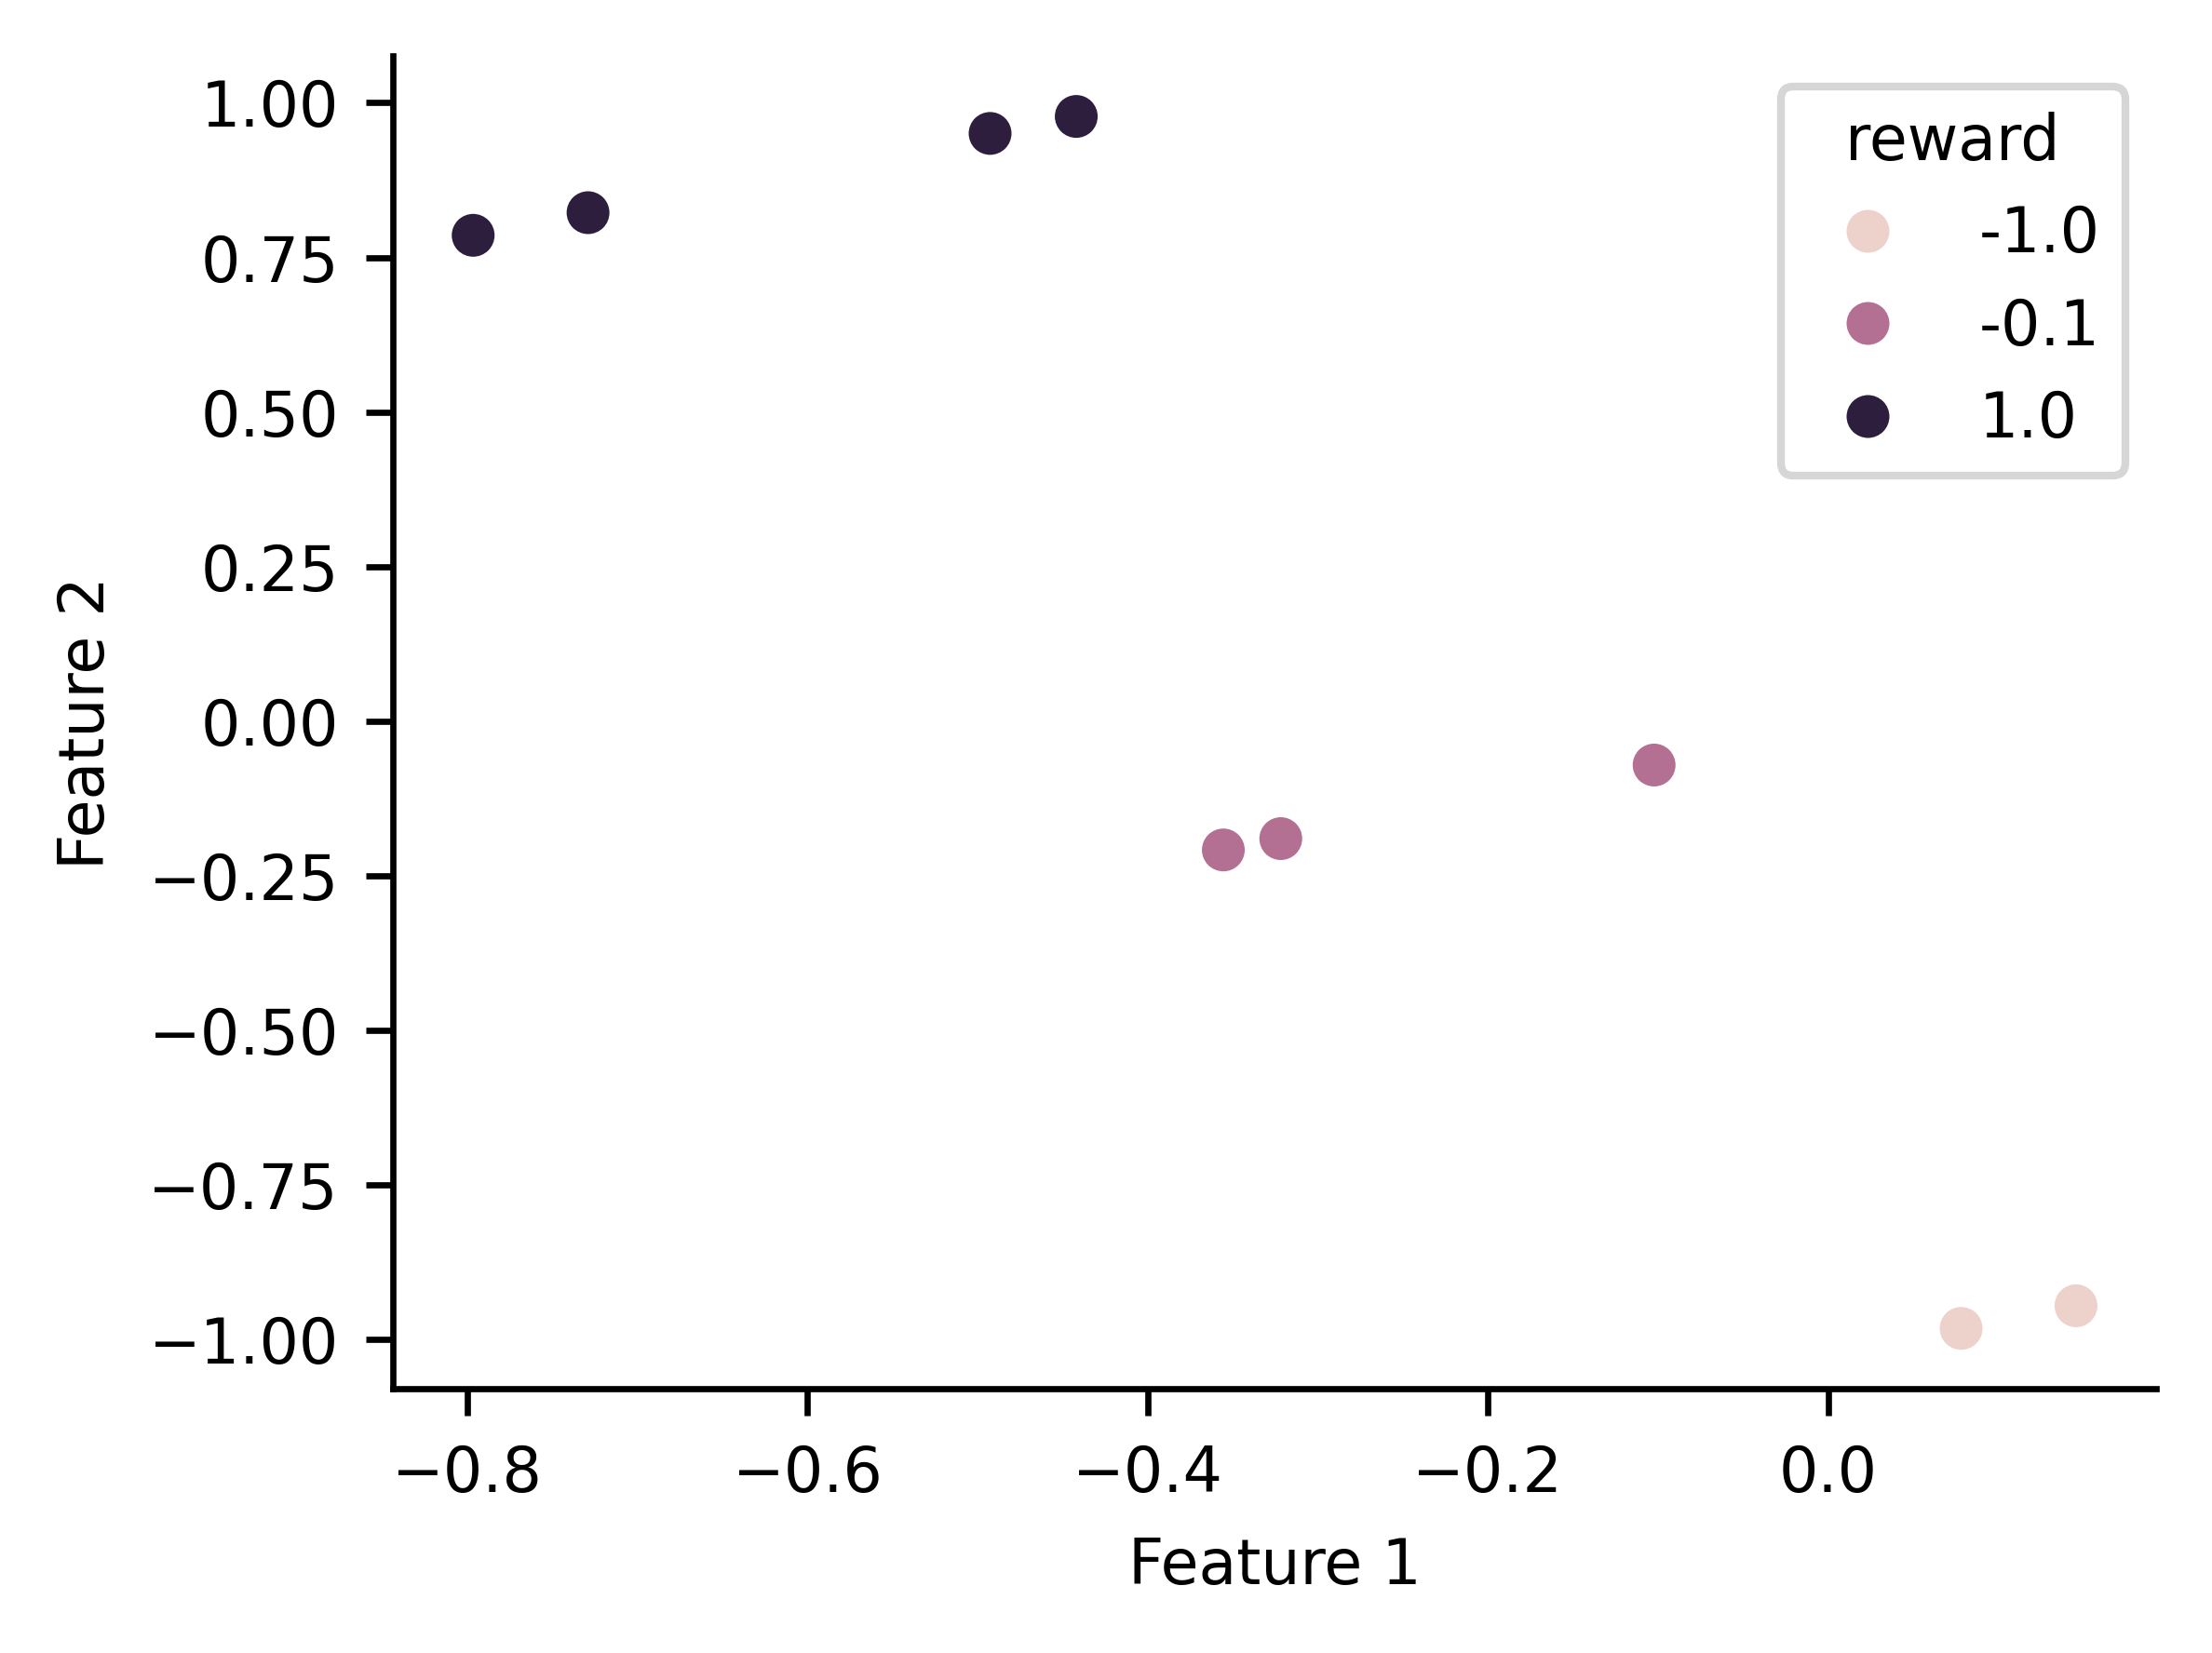

In [21]:
state_embeddings = np.array(state_embeddings)

# Create a DataFrame for plotting
plotting_data = {
    'feature 1': state_embeddings[:, 0],
    'feature 2': state_embeddings[:, 1],
    'reward': rewards_for_state
}
df = pd.DataFrame(plotting_data)

# Plotting
plt.figure(figsize=(4, 3))
sns.scatterplot(x='feature 1', y='feature 2',hue = 'reward',  data=df)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

### Clustering of the trajectories using X-Means

In [49]:
plotting_data = {
    'Delta i': [vec[0] for vec in state_embeddings],
    'Delta j': [vec[1] for vec in state_embeddings],
    'Rewards': rewards
}

df = pd.DataFrame(plotting_data)

# Plot setup
plt.figure(figsize=(4, 3))

# Prepare data for 'quiver'
# Assuming (0, 0) as the starting point for all vectors
X, Y = 0, 0  # Starting points
U = [vec[0] for vec in state_embeddings]  # Delta i (dx)
V = [vec[1] for vec in state_embeddings]  # Delta j (dy)

# Plot vectors
# Note: 'quiver' does not directly support hue-like functionality for colors based on 'Rewards'.
# You may need to adjust the color manually or use a loop to plot vectors with different conditions.
for i in range(len(U)):
    plt.quiver(X, Y, U[i], V[i], angles='xy', scale_units='xy', scale=1, width=0.002,
               color='red' if rewards[i] > 0 else 'blue')

plt.xlabel('Feature 1 (Delta i)')
plt.ylabel('Feature 2 (Delta j)')
plt.xlim(min(U), max(U))
plt.ylim(min(V), max(V))
plt.grid(True)
plt.show()

ValueError: All arrays must be of the same length

In [ ]:
# rewards =  [+1] * num_pos_trajs + [-1] * num_neg_trajs
# plt.figure(figsize=(6, 6))
# for vector, reward in zip(traveled_vectors, rewards):
#     # Determine color based on reward
#     color = 'blue' if reward == +1 else 'red'
    
#     # Draw the vector as an arrow
#     plt.arrow(0, 0, vector[0], vector[1], head_width=0.1, head_length=0.1, fc=color, ec=color)

# # Setting the plot limits
# plt.xlim(min([v[0] for v in traveled_vectors]) - 1, max([v[0] for v in traveled_vectors]) + 1)
# plt.ylim(min([v[1] for v in traveled_vectors]) - 1, max([v[1] for v in traveled_vectors]) + 1)

# plt.xlabel('Delta i')
# plt.ylabel('Delta j')
# plt.axhline(0, color='black',linewidth=0.5)
# plt.axvline(0, color='black',linewidth=0.5)
# plt.grid(True)
# plt.title('Traveled Vectors with Rewards')
# plt.show()

In [ ]:

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 8
initial_centers = kmeans_plusplus_initializer(differences_np, amount_initial_centers).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
xmeans_instance = xmeans(differences_np, initial_centers, 10)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
# print("Total WCE:", xmeans_instance.get_total_wce())
# print("Clusters:", clusters)
# print('Number of clusters', len(clusters))

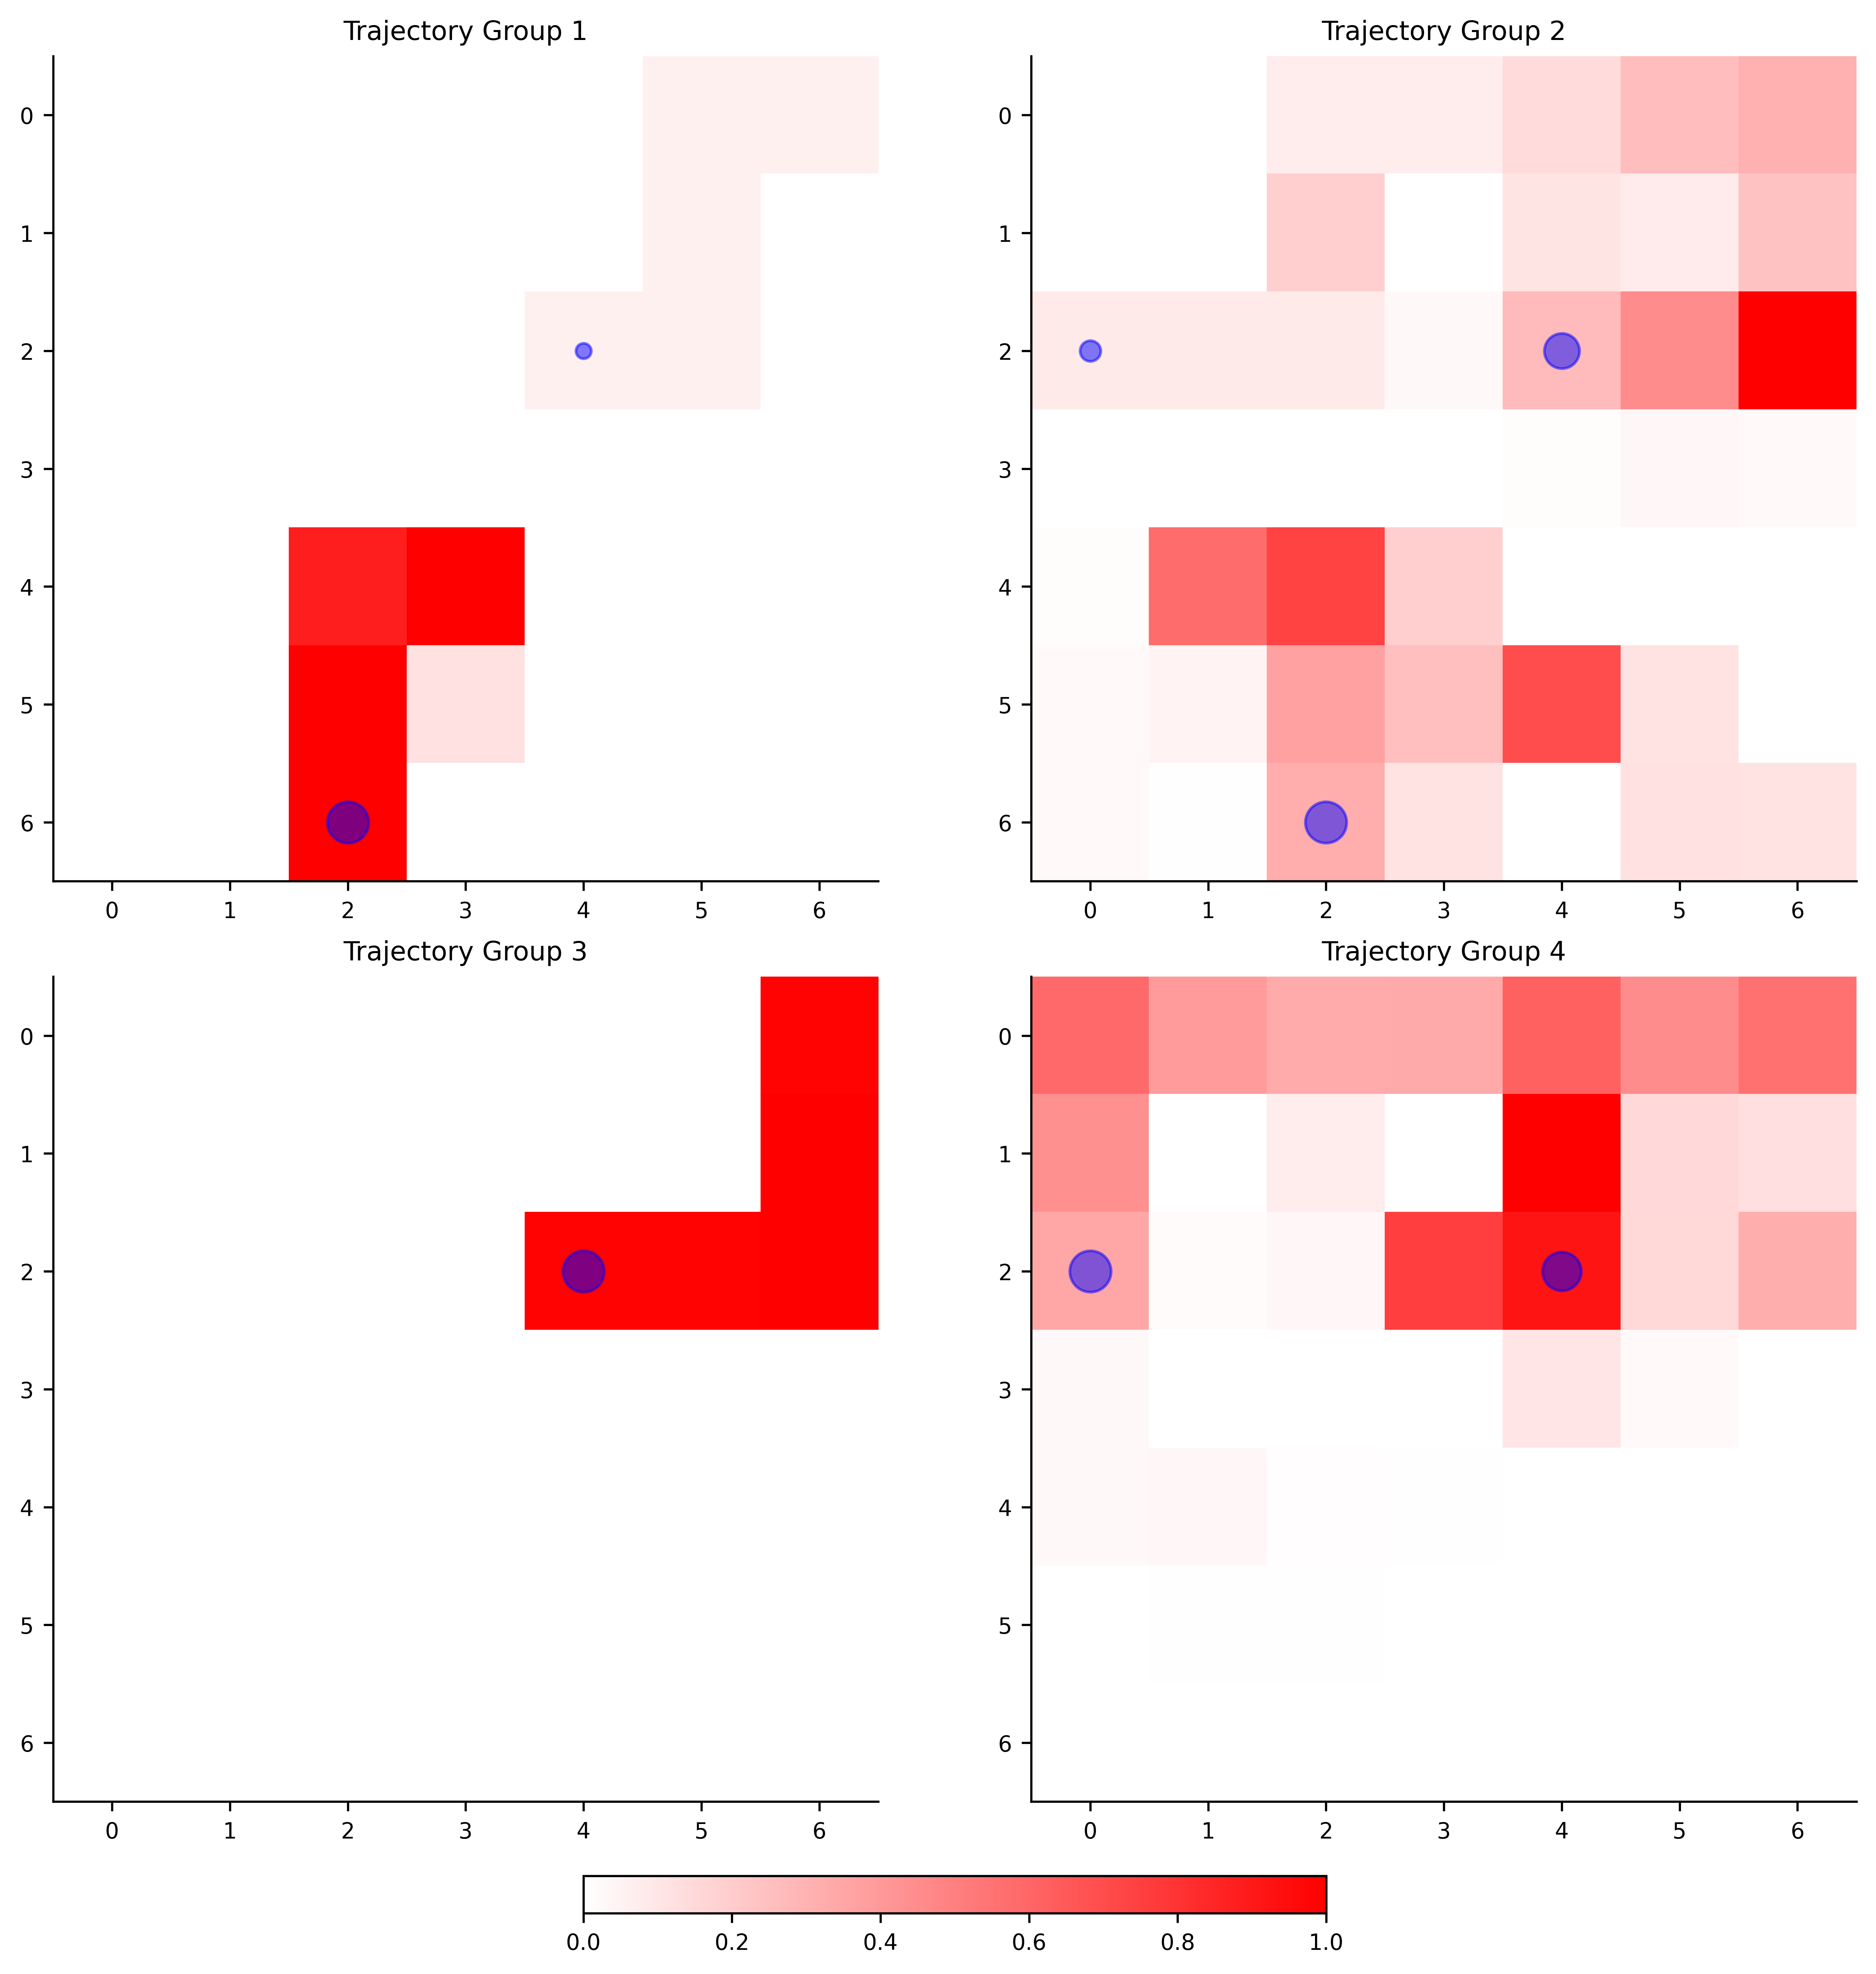

In [43]:
# Assuming 'clusters' is a list of clusters, each containing indices of trajectories in 'offline_data'
selected_clusters_indices = [0,1,2,3]  # Example selection of clusters for comparison

# Initialize a list to hold collected trajectories and starting points for each cluster
collected_clusters_trajectories = []
collected_clusters_starts = []

for cluster_index in selected_clusters_indices:
    collected_trcajectories = []
    start_points = np.zeros(shape=env.dim)  # Assuming env.dim gives the dimension of the grid

    for trajectory_idx in clusters[cluster_index]:
        selected_trajectory = offline_data[trajectory_idx]
        collected_trajectories.append(selected_trajectory)
        
        # Assuming each trajectory[0] is the starting state and you can convert it to grid coordinates
        start_state = selected_trajectory[0][0]  # [0] for the first state-action-reward tuple, [0] for the state
        start_i, start_j = env.idx_to_coords(start_state)  # Convert start state to coordinates
        start_points[start_i, start_j] += 1  # Increment start point count

    collected_clusters_trajectories.append(collected_trajectories)
    collected_clusters_starts.append(start_points)

env.plot_traj_densities_with_starts(collected_clusters_trajectories, collected_clusters_starts)

In [ ]:
def plot_traveled_vectors_from_start_points(start_points, traveled_vectors, rewards):
    """
    Plots traveled vectors as directed lines from their start points, with start points represented as dots,
    and colors indicating the reward. Sets the y-axis limit to (-1, 6).
    
    Args:
    - start_points: A list of (start_i, start_j) tuples representing the start points.
    - traveled_vectors: A list of (delta_i, delta_j) tuples representing the vectors.
    - rewards: A list of rewards corresponding to each vector, where +1 is blue and -1 is red.
    """
    plt.figure(figsize=(6, 3))
    for start_point, vector, reward in zip(start_points, traveled_vectors, rewards):
        color = 'blue' if reward == 1 else 'red'  # Color based on reward
        start_i, start_j = start_point  # Start coordinates
        end_i, end_j = start_i + vector[0], start_j + vector[1]  # End coordinates based on vector
        # Plot the vector as an arrow
        plt.arrow(start_i, start_j, vector[0], vector[1], head_width=0.1, head_length=0.15, fc=color, ec=color)
        # Plot the start point as a dot
        plt.plot(start_i, start_j, 'o', color='black', markersize=3)
    
    # Setting axis labels and title
    plt.xlabel('i')
    plt.ylabel('j')
    plt.grid(True)
    plt.axis('equal')
    plt.title('Traveled Vectors from Start Points with Rewards')
    plt.ylim(-1, 15)
    plt.show()
    
def calculate_start_points_and_vectors(offline_data):
    """
    Calculates start points and traveled vectors from a list of trajectories.
    
    Args:
    - offline_data: A list of trajectories, each trajectory is a list of states,
      and each state is represented by coordinates (i, j).
    
    Returns:
    - start_points: A list of (i, j) tuples representing the start points of each trajectory.
    - traveled_vectors: A list of (delta_i, delta_j) tuples representing the traveled vector 
      from start to end of each trajectory.
    """
    start_points = []
    traveled_vectors = []

    for traj in offline_data:
        if not traj:  # Check if the trajectory is empty
            continue

        # Extract start and end points
        start_point = traj[0][:2]
        end_point = traj[-1][:2]

        # Calculate the traveled vector
        vector = (end_point[0] - start_point[0], end_point[1] - start_point[1])

        # Append to lists
        start_points.append(start_point)
        traveled_vectors.append(vector)

    return start_points, traveled_vectors

start_points, traveled_vectors = calculate_start_points_and_vectors(offline_data)
plot_traveled_vectors_from_start_points(start_points, differences_np, rewards)

In [ ]:
# for cluster_id, cluster in enumerate(clusters):
#     print('-'*10)
#     print('Cluster ID', cluster_id)
#     for traj_id in cluster:
#         env.plot_traj(offline_data[traj_id])    
#     print('-'*10)

In [ ]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id


In [ ]:
palette = sns.color_palette('husl', len(clusters) + 1)
palette

In [ ]:
# cluster_data_embeds = [result_data_combinations[cid][1] for cid in result_data_combinations]
# cluster_data_embeds.pop(0)

plotting_data = {'feature 1': pca_traj_embeds[:, 0],
                 'feature 2': pca_traj_embeds[:, 1],
                 'cluster id': traj_cluster_labels}
df = pd.DataFrame(plotting_data)

plt.figure(figsize=(4,3))
data_ax = sns.scatterplot(x='feature 1',
                          y='feature 2',
                          hue='cluster id',
                          palette=palette[:len(clusters)],
                          data=df,
                          legend=True)
plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
# plt.legend(title = '$c_{j}$', loc='center left', bbox_to_anchor=(1., 0.7), ncol=2)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
plt.tight_layout()
plt.savefig('./traj_clustering_grid.pdf')
plt.show()

## Encode sets of trajectories

In [ ]:
def get_data_embedding(traj_embeddings):
#     return np.exp(np.abs(np.array(traj_embeddings).sum(axis=0)/100.))/np.sum(np.abs(np.exp(np.array(traj_embeddings).sum(axis=0)/100.)))
    return np.exp(np.array(traj_embeddings).sum(axis=0)/10.)/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/10.))

data_embedding = get_data_embedding(traj_embeddings)

### Train models on different cluster combinations

In [ ]:
transition_model, reward_model = generate_model(env, offline_data)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

In [ ]:
result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data):
        if traj_id not in cluster:
            temp_data.append(offline_data[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

### Generate attributions

In [ ]:
attributions = []

for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals:
        continue
        
    orig_state_action_values = action_values[state]
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)
    
    responsible_data_combination = np.argsort(distances)[0]
    
    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)

In [ ]:
attributions

In [ ]:
results_save_dir = './gridworld_results/grid_7by7/'
if not os.path.exists(results_save_dir):
    os.makedirs(results_save_dir)


# for traj_id, traj in enumerate(offline_data):
#     env.plot_traj(traj, path=os.path.join(results_save_dir, 'traj_' + str(traj_id) + '.png'))


In [ ]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
# Data to save
data_to_be_saved = [
    {
        'attributions' : attributions,
    }
]

dumped = json.dumps(data_to_be_saved, cls=NumpyEncoder)

with open(os.path.join(results_save_dir, 'attribution_results.json'), 'w') as f:
    json.dump(dumped, f)

In [ ]:
attributions

## Initial State Value Estimates

In [ ]:
for data_combination_id in result_data_combinations:
    print(result_data_combinations[data_combination_id][0].max(axis=1).mean())

## Average delta q

In [ ]:
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    print(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))

## Compare the actions

In [ ]:
action_comparison = {}
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    action_comparison[data_combination_id] = 0
    for i in range(env_width*env_height):
            orig_actions = np.where(result_data_combinations[0][0][i] == np.max(result_data_combinations[0][0][i]))[0]
            alternate_actions = np.where(result_data_combinations[data_combination_id][0][i] == np.max(result_data_combinations[data_combination_id][0][i]))[0]
            
            if list(orig_actions) == list(alternate_actions):
                action_comparison[data_combination_id] += 1 
#             alternate_actions = 
#     print(np.sum(np.argmax(action_values_new, axis=1) != np.argmax(result_data_combinations[0][0], axis=1))/(env_width*env_height))

In [ ]:
np.array(list(action_comparison.values()))/(env_width*env_height)

## Data distances

In [ ]:
data_distances = np.zeros(len(result_data_combinations))
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding, data_embedding_new)

In [ ]:
with np.printoptions(precision=5, suppress=True):
    print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))

## Cluster Attribution Frequency

In [ ]:
cluster_attr_freq = np.zeros(len(clusters))

In [ ]:
for attribution in attributions:
    cluster_attr_freq[attribution['responsible_cluster']] += 1 

In [ ]:
cluster_attr_freq/cluster_attr_freq.sum()